## Data Preprocessing Script

This notebook is used to preprocess the data before training the model. The following steps are performed in this notebook:
1. Data Splitting: The data is split into training/validation and test sets.
2. Data Augmentation: The training data is augmented using several computer vision augmentation techniques.

In [1]:
# Imports
import cv2
import numpy as np
import os
import shutil
import random
from typing import List, Tuple

### Data Splitting

Creation of a training/validation and test set from the original data. The test set will not be augmented. A percentage full dataset will be moved to the /data/test folder. Another percentage will be moved to the /data/train_val folder and will be augmented.

In [32]:
ORIGINAL_DATA_FOLDER = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification"

# Percentage of the dataset to be used for the test set
TEST_SET_PERCENTAGE = 0.2
# Percentage of the dataset to be used for the train/validation set
TRAIN_VAL_SET_PERCENTAGE = 1 - TEST_SET_PERCENTAGE

# For each folder representing a class in the dataset, in \\data\\images\\, copy a percentage of the images to a test set hosted in \\data\\test and the rest to a train/validation set hosted in \\data\\train_val\\original\\
def create_sets():
    # Create the test set folder
    if not os.path.exists(ORIGINAL_DATA_FOLDER + "\\final_test"):
        os.makedirs(ORIGINAL_DATA_FOLDER + "\\final_test")

    # Create directories for the train/validation set
    if not os.path.exists(ORIGINAL_DATA_FOLDER + "\\final_train_val\\original"):
        os.makedirs(ORIGINAL_DATA_FOLDER + "\\final_train_val\\original")
        
    # Get the list of folders in the images directory
    folders = [f for f in os.listdir(ORIGINAL_DATA_FOLDER + "\\images") if os.path.isdir(os.path.join(ORIGINAL_DATA_FOLDER + "\\images", f))]
    # For each folder
    for folder in folders:
        # Get the list of images in the folder
        images = [f for f in os.listdir(os.path.join(ORIGINAL_DATA_FOLDER + "\\images", folder)) if os.path.isfile(os.path.join(ORIGINAL_DATA_FOLDER + "\\images", folder, f))]
        # Get the number of images to copy to the test set
        num_images_test = int(len(images) * TEST_SET_PERCENTAGE)
        # Get the number of images to copy to the train/validation set
        num_images_train_val = int(len(images) * TRAIN_VAL_SET_PERCENTAGE)

        if num_images_train_val + num_images_test > len(images):
            num_images_train_val = num_images_train_val - (num_images_test + num_images_train_val - len(images))

        # Create the folder for the class in the test
        if not os.path.exists(ORIGINAL_DATA_FOLDER + "\\final_test\\" + folder):
            os.makedirs(ORIGINAL_DATA_FOLDER + "\\final_test\\" + folder)

        # Create the folder for the class in the train/validation set
        if not os.path.exists(ORIGINAL_DATA_FOLDER + "\\final_train_val\\original\\" + folder):
            os.makedirs(ORIGINAL_DATA_FOLDER + "\\final_train_val\\original\\" + folder)
        
        # Copy the images to the test set and the train/validation set based on index
        for index in range(num_images_test + num_images_train_val):
            # Get the image to copy
            image = images.pop(random.randint(0, len(images) - 1))

            if index < num_images_test:
                # Copy the image to the test set
                shutil.copy(os.path.join(ORIGINAL_DATA_FOLDER + "\\images", folder, image), os.path.join(ORIGINAL_DATA_FOLDER + "\\final_test", folder, image))
            else:
                # Copy the image to the train/validation set
                shutil.copy(os.path.join(ORIGINAL_DATA_FOLDER + "\\images", folder, image), os.path.join(ORIGINAL_DATA_FOLDER + "\\final_train_val\\original", folder, image))


create_sets()

### Data Augmentation

The training/validation set will be augmented using the following techniques:
- Random rotation
- Horizontal flip
- Brightness adjustment
- Saturation adjustment
- Sharpening
- Blur
- Cropping

We start by creating a function that loads the data in the folders containing the images and their respective labels.

In [2]:
# Load Data from /data directory, in the folders with each class, each containing images of the respective class in .png format
def load_image_paths_and_labels(dir: str) -> Tuple[List[str], List[str]]:
    image_paths = []
    labels = []
    for folder in os.listdir(dir):
        folder_path = os.path.join(dir, folder)
        if not os.path.isdir(folder_path):
            continue
        for file in os.listdir(folder_path):
            image_paths.append(os.path.join(folder_path, file))
            labels.append(folder)
    return image_paths, labels

Then, we define a set of transformation functions that will be applied to the images. These functions are used to augment the training data.

In [3]:
# Flip an image horizontally, vertically or both
def flip_image(image: np.ndarray, horizontal: bool = True, vertical: bool = False) -> np.ndarray:
    if horizontal and vertical:
        flipped_image = cv2.flip(image, -1)
    elif horizontal:
        flipped_image = cv2.flip(image, 1)
    elif vertical:
        flipped_image = cv2.flip(image, 0)
    else:
        return image
    return flipped_image

# Rotate an image by a given angle
def rotate_image(image: np.ndarray, angle: float) -> np.ndarray:
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated_image = cv2.warpAffine(image, matrix, (w, h), borderValue=(0, 0, 0))
    return rotated_image

# Adjust the brightness of an image
def adjust_brightness(image: np.ndarray, value: int) -> np.ndarray:
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    v = cv2.add(v, value)
    v = np.clip(v, 0, 255)
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

# Adjust the saturation of an image
def adjust_saturation(image: np.ndarray, value: int) -> np.ndarray:
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)
    s = cv2.add(s, value)
    s = np.clip(s, 0, 255)
    final_hsv = cv2.merge((h, s, v))
    return cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)

# Apply a sharpening kernel to an image
def apply_sharpen(image: np.ndarray) -> np.ndarray:
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])
    return cv2.filter2D(image, -1, kernel)

# Apply a Gaussian blur to an image
def apply_blur(image: np.ndarray, ksize: int = 7) -> np.ndarray:
    return cv2.GaussianBlur(image, (ksize, ksize), 0)

# Crop an image
def crop(img: np.ndarray) -> np.ndarray:
    size = img.shape[:2]
    kernel_size = list(map(lambda x: int(x * 0.8), size))
    shift_min, shift_max = -50, 50
    shift_size = [np.random.randint(shift_min, shift_max), np.random.randint(shift_min, shift_max)]

    crop_img = img[
        (size[0] - kernel_size[0]) // 2 + shift_size[0]:(size[0] - kernel_size[0]) // 2 + kernel_size[0] + shift_size[0],
        (size[1] - kernel_size[1]) // 2 + shift_size[1]:(size[1] - kernel_size[1]) // 2 + kernel_size[1] + shift_size[1]
    ]
    
    return np.uint8(crop_img)

We then define a function that applies the transformations to the images, with a given probability per transformation, meaning that not all transformations will be applied to each image. This was done due to the dataset being already too large.

In [4]:
# Augment an image with geometric transformations, color distortions and kernel filters, with a given chance per transformation
def augment_image(image: np.ndarray, augment_chance: float) -> List[np.ndarray]:
    augmented_images = [image]

    # Geometric transformations
    if random.random() < augment_chance:
        augmented_images.append(flip_image(image, horizontal=True))

    # Rotation: Apply rotation from -40 to 40 degrees
    rotation_range = [-40, 40]
    if random.random() < augment_chance:
        angle = np.random.uniform(rotation_range[0], rotation_range[1])
        augmented_images.append(rotate_image(image, angle))

    # Color distortions
    if random.random() < augment_chance:
        augmented_images.append(adjust_brightness(image, random.choice([-50, 50])))
    if random.random() < augment_chance:
        augmented_images.append(adjust_saturation(image, random.choice([-50, 50])))

    # Kernel filters
    if random.random() < augment_chance:
        augmented_images.append(apply_sharpen(image))
    if random.random() < augment_chance:
        augmented_images.append(apply_blur(image, random.choice([3, 5, 7])))

    return augmented_images


We showcase the transformations on a sample image below.

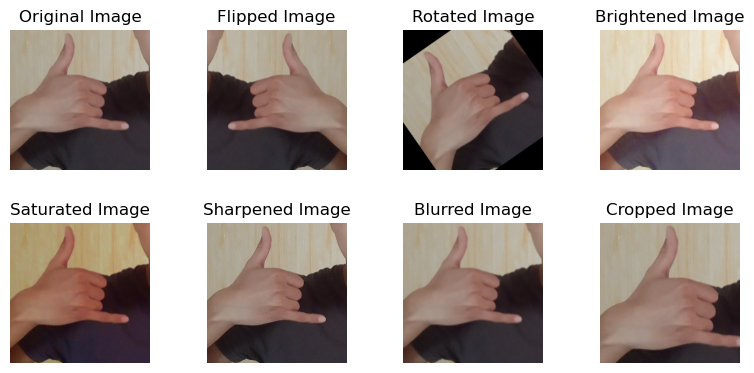

In [13]:
from matplotlib import pyplot as plt

# Load sample image
img = cv2.imread("D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\test\\call\\0a8c60fc-9ef4-4de5-b601-3dee17ee110d.jpeg")

# Define the figure size
fig, axs = plt.subplots(2, 4, figsize=(8, 4))
fig.tight_layout(pad=1.0)

# Function to show images in the grid
def show_image(ax, img, title):
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(title)
    ax.axis("off")

# Original Image
show_image(axs[0, 0], img, "Original Image")

# Flip image horizontally
flipped_image = flip_image(img, horizontal=True)
show_image(axs[0, 1], flipped_image, "Flipped Image")

# Rotate image by random angle between -40 and 40 degrees
angle = np.random.uniform(-40, 40)
rotated_image = rotate_image(img, angle)
show_image(axs[0, 2], rotated_image, "Rotated Image")

# Adjust brightness
brightened_image = adjust_brightness(img, 50)
show_image(axs[0, 3], brightened_image, "Brightened Image")

# Adjust saturation
saturated_image = adjust_saturation(img, 50)
show_image(axs[1, 0], saturated_image, "Saturated Image")

# Apply sharpening
sharpened_image = apply_sharpen(img)
show_image(axs[1, 1], sharpened_image, "Sharpened Image")

# Apply blur
blurred_image = apply_blur(img)
show_image(axs[1, 2], blurred_image, "Blurred Image")

# Crop image
cropped_image = crop(img)
show_image(axs[1, 3], cropped_image, "Cropped Image")

plt.show()

We then create a function that processes and augments the training data and saves it to the /data/train_val/augmented folder, but in batches, to avoid memory issues.

In [37]:
# Function that processes and saves batches of images with labels
def process_and_save_batches(
    image_paths: List[str],
    labels: List[str],
    batch_size: int,
    output_dir: str,
    augmentation_chance: float
):
    os.makedirs(output_dir, exist_ok=True)

    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i : i + batch_size]
        batch_labels = labels[i : i + batch_size]

        for img_path, label in zip(batch_paths, batch_labels):
            img = cv2.imread(img_path)
            img = cv2.resize(img, (300, 300))

            augmented_images = augment_image(img, augmentation_chance)

            label_dir = os.path.join(output_dir, label)
            os.makedirs(label_dir, exist_ok=True)

            for j, aug_img in enumerate(augmented_images):
                img_name = f"{os.path.splitext(os.path.basename(img_path))[0]}_aug_{j}.jpeg"
                img_path = os.path.join(label_dir, img_name)
                cv2.imwrite(img_path, aug_img)


We use the functions defined above to process the data and save it to the /data/train_val/augmented folder.

In [38]:
# Load image paths and labels
image_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\final_train_val\\original"
image_paths, labels = load_image_paths_and_labels(image_dir)

# Process and save images in batches
batch_size = 100
percentage_augmentation = 0.15
output_dir = "D:\\Documents\\GitHub\\cv-gesture-recognition\\data\\classification\\final_train_val\\augmented"
process_and_save_batches(image_paths, labels, batch_size, output_dir, percentage_augmentation)